In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
import glob
from torchvision import models
import numpy as np
from PIL import Image
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore", message="The parameter 'pretrained' is deprecated")
warnings.filterwarnings("ignore", message="Arguments other than a weight enum or `None` for 'weights' are deprecated")

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        vgg16 = models.vgg16(pretrained=True)

        self.features = nn.Sequential(
            vgg16.features[0:10], 
        )

    
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
    
        )
        
        self.conv_2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=(1, 1))
        self.conv_3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1))  # Skip connection
        self.conv_3_relu = nn.ReLU(inplace=True)

       
        self.regressor = nn.Sequential(
            nn.Linear(64 * 56 * 56, 4096), 
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.LayerNorm(4096), 
            nn.Dropout(p=0.3),
            nn.Linear(4096, 2048),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.LayerNorm(2048),  
            nn.Dropout(p=0.3),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Linear(1024,1 )
        )

    def forward(self, x):
        x = self.features(x)

        x1 = self.conv_1(x)
        x2 = self.conv_2(x1)
        
        # Skip connection
        skip = self.conv_3(x)
        skip = self.conv_3_relu(skip)

        # Add skip connection
        x = x2 + skip

        # Flatten the feature map
        x = torch.flatten(x, 1)

        # Pass through the regressor
        x = self.regressor(x)
        return x


# Instantiate and move to device
custom_model = CustomCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = custom_model.to(device)

print(model)

# Test the model with a sample input
sample_input = torch.randn(4, 3, 224, 224).to(device)  # Input size (4 batches, 3 channels, 224x224)
output = model(sample_input)
print(output)


CustomCNN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_1): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): C

In [5]:
for param in model.features.parameters():
    param.requires_grad = False

In [6]:
'''mean is 0, and standard deviation varies randomly between 0.01 and 0.20'''

def add_noise(image_np, sigma):
    noisy_image = image_np + np.random.randn(*image_np.shape) * sigma
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image.astype(np.float32)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image) 
    
     
        image_np = image.permute(1, 2, 0).numpy()  # Convert the tensor to a NumPy array

        sigma = np.random.uniform(0.01, 0.20) # Random sigma value

        # Add noise to the image
        noisy_image_np = add_noise(image_np, sigma)

        # Convert the noisy image back to a PyTorch tensor
        noisy_image = torch.tensor(noisy_image_np).permute(2, 0, 1)  # Back to (C, H, W)
    
        return noisy_image.float(), sigma



In [8]:
sigma = np.random.uniform(0.01, 0.20, 5)
print(sigma)

[0.06731297 0.17468886 0.04577907 0.08695193 0.09286244]


In [9]:
from tqdm import tqdm 
from sklearn.metrics import mean_absolute_error, r2_score

def train(model, dataloader, loss_fn, optimizer, epoch, writer, device):
    model.train()
    running_loss = 0.0
    all_preds, all_targets = [], []

    for batch_idx, (data, target) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch} (Training)')):
        data, target = data.to(device), target.to(device).float()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output.squeeze(), target)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        
        running_loss += loss.item()

        # Collect predictions and targets for metric calculation
        all_preds.extend(output.squeeze().detach().cpu().numpy())  # Detach the tensor here
        all_targets.extend(target.cpu().numpy())

    avg_loss = running_loss / len(dataloader)

    # Calculate metrics
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    print(f'Epoch [{epoch}], Train Loss: {avg_loss:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

    # Logging metrics
    writer.add_scalar('Training Loss', avg_loss, epoch)
    writer.add_scalar('Training MAE', mae, epoch)
    writer.add_scalar('Training R2', r2, epoch)



In [10]:
import torch
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def test(model, dataloader, loss_fn, epoch, writer, device):
    model.eval() 
    running_loss = 0.0
    all_preds, all_targets = [], []

    with torch.no_grad(): 
        for data, target in tqdm(dataloader, desc=f'Epoch {epoch} (Testing)'):
            data, target = data.to(device), target.to(device).float()

            output = model(data)

            loss = loss_fn(output.squeeze(), target)

            running_loss += loss.item()
            all_preds.extend(output.squeeze().cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_loss = running_loss / len(dataloader)

    mae = mean_absolute_error(all_targets, all_preds)
    mse = mean_squared_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    # Print the first 5 true and predicted sigmas
    print(f"True sigmas: {all_targets[:5]}")
    print(f"Model predicted sigmas: {all_preds[:5]}")

    print(f'Epoch [{epoch}], Test Loss: {avg_loss:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')
    
    writer.add_scalar('Test Loss', avg_loss, epoch)
    writer.add_scalar('Test MAE', mae, epoch)
    writer.add_scalar('Test R2', r2, epoch)


In [11]:
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Directory where your images are stored
image_dir = 'D:/Dr. Jarez Miah_Don\'t delete/face dataset/CelebA/img_align_celeba/img_align_celeba/'

# List all images in the directory
images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Shuffle the list to randomize the image order
random.shuffle(images)

# Perform 70-30 split
train_images, val_images = train_test_split(images, test_size=0.3, random_state=42)

# Create datasets
train_dataset = CustomDataset(image_paths=train_images, transform=transform)
val_dataset = CustomDataset(image_paths=val_images, transform=transform)

# Create DataLoaders
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

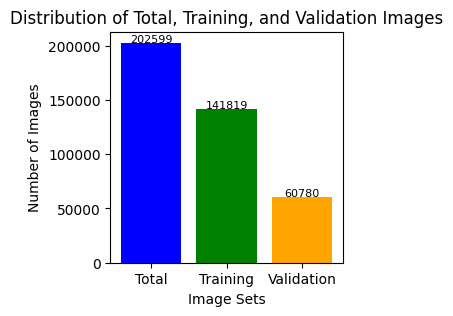

In [9]:
# Check the split sizes
total_images = len(images)
training_images = len(train_images)
validation_images = len(val_images)

# Labels for the bars
labels = ['Total', 'Training', 'Validation']

# Data for the bars
image_counts = [total_images, training_images, validation_images]

# Create the bar chart
plt.figure(figsize=(3,3))
plt.bar(labels, image_counts, color=['blue', 'green', 'orange'])

# Add titles and labels
plt.title('Distribution of Total, Training, and Validation Images')
plt.xlabel('Image Sets')
plt.ylabel('Number of Images')

# Show the values on top of each bar
for i, count in enumerate(image_counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=8)

# Display the plot
plt.show()



In [10]:
for X,y in valloader:
    print(X.max(), X.min())
    print(X.shape)
    print(y.shape)
    break

tensor(1.) tensor(0.)
torch.Size([16, 3, 224, 224])
torch.Size([16])


In [11]:
for X,y in valloader:
    print(y)
    break
    

tensor([0.1661, 0.1469, 0.1058, 0.1454, 0.0186, 0.0344, 0.0766, 0.0455, 0.1586,
        0.1722, 0.0108, 0.1259, 0.1808, 0.0766, 0.0308, 0.1821],
       dtype=torch.float64)


In [11]:
from tqdm import tqdm 
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    """ Calculate MAPE as a custom function since sklearn does not have a built-in function for it. """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train(model, dataloader, loss_fn, optimizer, epoch, device):
    model.train()
    running_loss = 0.0
    all_preds, all_targets = [], []

    for batch_idx, (data, target) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch} (Training)')):
        data, target = data.to(device), target.to(device).float()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output.squeeze(), target)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        
        running_loss += loss.item()

        # Collect predictions and targets for metric calculation
        all_preds.extend(output.squeeze().detach().cpu().numpy())  # Detach the tensor here
        all_targets.extend(target.cpu().numpy())

    avg_loss = running_loss / len(dataloader)

    # Calculate metrics
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    mape = mean_absolute_percentage_error(all_targets, all_preds)
    rmse = mean_squared_error(all_targets, all_preds, squared=False)  # Calculate RMSE
    try:
        rmsle = mean_squared_log_error(all_targets, all_preds, squared=False)
    except ValueError:
        # Handling the case where the target contains negative values (RMSLE is undefined)
        rmsle = float('nan')

    print(f'Epoch [{epoch}], Train Loss (MSE): {avg_loss:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, MAPE: {mape:.4f}, RMSE: {rmse:.4f}, RMSLE: {rmsle:.4f}')

    '''Logging metrics
    writer.add_scalar('Training Loss', avg_loss, epoch)
    writer.add_scalar('Training MAE', mae, epoch)
    writer.add_scalar('Training R2', r2, epoch)
    writer.add_scalar('Training MAPE', mape, epoch)
    writer.add_scalar('Training RMSE', rmse, epoch)
    writer.add_scalar('Training RMSLE', rmsle, epoch)'''


In [12]:
import torch
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    """ Calculate MAPE as a custom function since sklearn does not have a built-in function for it. """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def test(model, dataloader, loss_fn, epoch, device):
    model.eval() 
    running_loss = 0.0
    all_preds, all_targets = [], []

    with torch.no_grad(): 
        for data, target in tqdm(dataloader, desc=f'Epoch {epoch} (Testing)'):
            data, target = data.to(device), target.to(device).float()

            output = model(data)

            loss = loss_fn(output.squeeze(), target)

            running_loss += loss.item()
            all_preds.extend(output.squeeze().cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_loss = running_loss / len(dataloader)

    # Calculate metrics
    mae = mean_absolute_error(all_targets, all_preds)
    mse = mean_squared_error(all_targets, all_preds)
    rmse = mean_squared_error(all_targets, all_preds, squared=False)  # RMSE
    r2 = r2_score(all_targets, all_preds)
    mape = mean_absolute_percentage_error(all_targets, all_preds)
    
    try:
        rmsle = mean_squared_log_error(all_targets, all_preds, squared=False)
    except ValueError:
        # Handling the case where the target contains negative values (RMSLE is undefined)
        rmsle = float('nan')

    # Print the first 5 true and predicted sigmas
    print(f"True sigmas: {all_targets[:5]}")
    print(f"Model predicted sigmas: {all_preds[:5]}")

    
    print(f'Epoch [{epoch}], Test Loss (MSE): {avg_loss:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, MAPE: {mape:.4f}, RMSE: {rmse:.4f}, RMSLE: {rmsle:.4f}')
    '''
    # Logging metrics
    writer.add_scalar('Test Loss', avg_loss, epoch)
    writer.add_scalar('Test MAE', mae, epoch)
    writer.add_scalar('Test RMSE', rmse, epoch)
    writer.add_scalar('Test MAPE', mape, epoch)
    writer.add_scalar('Test RMSLE', rmsle, epoch)
    writer.add_scalar('Test R2', r2, epoch)
    '''


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.MSELoss()
#writer = SummaryWriter()
epochs = 25
for epoch in range(1, epochs + 1):
    train(model, trainloader, loss_fn, optimizer, epoch,device)
    test(model, valloader, loss_fn, epoch,  device)
    scheduler.step()

Epoch 1 (Training): 100%|████████████████████████████████████████████████████████| 8864/8864 [6:31:54<00:00,  2.65s/it]


Epoch [1], Train Loss (MSE): 0.0016, MAE: 0.0146, R2: 0.4847, MAPE: 22.3393, RMSE: 0.0394, RMSLE: nan


Epoch 1 (Testing): 100%|█████████████████████████████████████████████████████████| 3799/3799 [2:57:43<00:00,  2.81s/it]


True sigmas: [0.1149499, 0.17344068, 0.09550491, 0.08989692, 0.08709903]
Model predicted sigmas: [0.11735063, 0.18838571, 0.09086937, 0.08645917, 0.08634175]
Epoch [1], Test Loss (MSE): 0.0001, MAE: 0.0059, R2: 0.9809, MAPE: 6.3392, RMSE: 0.0076, RMSLE: 0.0066


Epoch 2 (Training): 100%|████████████████████████████████████████████████████████| 8864/8864 [6:32:50<00:00,  2.66s/it]


Epoch [2], Train Loss (MSE): 0.0001, MAE: 0.0061, R2: 0.9787, MAPE: 7.9873, RMSE: 0.0080, RMSLE: nan


Epoch 2 (Testing): 100%|█████████████████████████████████████████████████████████| 3799/3799 [2:00:33<00:00,  1.90s/it]


True sigmas: [0.0162718, 0.08302461, 0.07664487, 0.13024901, 0.15831652]
Model predicted sigmas: [0.018374491, 0.0830017, 0.07504634, 0.1288241, 0.15633623]
Epoch [2], Test Loss (MSE): 0.0000, MAE: 0.0044, R2: 0.9896, MAPE: 6.0055, RMSE: 0.0056, RMSLE: 0.0050


Epoch 3 (Training): 100%|████████████████████████████████████████████████████████| 8864/8864 [4:14:58<00:00,  1.73s/it]


Epoch [3], Train Loss (MSE): 0.0000, MAE: 0.0053, R2: 0.9844, MAPE: 7.5468, RMSE: 0.0068, RMSLE: 0.0061


Epoch 3 (Testing): 100%|█████████████████████████████████████████████████████████| 3799/3799 [1:37:14<00:00,  1.54s/it]


True sigmas: [0.19324985, 0.08915986, 0.06697732, 0.19353181, 0.041612647]
Model predicted sigmas: [0.19426546, 0.08776113, 0.06909317, 0.1934484, 0.04468657]
Epoch [3], Test Loss (MSE): 0.0000, MAE: 0.0031, R2: 0.9946, MAPE: 4.6225, RMSE: 0.0040, RMSLE: 0.0036


Epoch 4 (Training): 100%|████████████████████████████████████████████████████████| 8864/8864 [3:45:22<00:00,  1.53s/it]


Epoch [4], Train Loss (MSE): 0.0000, MAE: 0.0051, R2: 0.9856, MAPE: 7.4368, RMSE: 0.0066, RMSLE: 0.0059


Epoch 4 (Testing): 100%|█████████████████████████████████████████████████████████| 3799/3799 [1:05:48<00:00,  1.04s/it]


True sigmas: [0.112717204, 0.12114911, 0.042056635, 0.19922738, 0.10171394]
Model predicted sigmas: [0.11633363, 0.12101196, 0.04507154, 0.19454394, 0.10874377]
Epoch [4], Test Loss (MSE): 0.0000, MAE: 0.0040, R2: 0.9919, MAPE: 5.9765, RMSE: 0.0049, RMSLE: 0.0044


Epoch 5 (Training): 100%|████████████████████████████████████████████████████████| 8864/8864 [1:36:17<00:00,  1.53it/s]


Epoch [5], Train Loss (MSE): 0.0000, MAE: 0.0050, R2: 0.9859, MAPE: 7.3198, RMSE: 0.0065, RMSLE: 0.0058


Epoch 5 (Testing): 100%|███████████████████████████████████████████████████████████| 3799/3799 [18:26<00:00,  3.43it/s]


True sigmas: [0.023802297, 0.09550525, 0.03348627, 0.10267892, 0.069601536]
Model predicted sigmas: [0.023875747, 0.09443154, 0.034783382, 0.10269735, 0.07181428]
Epoch [5], Test Loss (MSE): 0.0000, MAE: 0.0039, R2: 0.9910, MAPE: 4.9397, RMSE: 0.0052, RMSLE: 0.0046


Epoch 6 (Training): 100%|████████████████████████████████████████████████████████| 8864/8864 [2:48:45<00:00,  1.14s/it]


Epoch [6], Train Loss (MSE): 0.0000, MAE: 0.0037, R2: 0.9923, MAPE: 5.6318, RMSE: 0.0048, RMSLE: 0.0043


Epoch 6 (Testing): 100%|███████████████████████████████████████████████████████████| 3799/3799 [34:06<00:00,  1.86it/s]


True sigmas: [0.07250609, 0.14661804, 0.03658213, 0.038491, 0.18947837]
Model predicted sigmas: [0.07371949, 0.14555164, 0.037786864, 0.039699562, 0.19276555]
Epoch [6], Test Loss (MSE): 0.0000, MAE: 0.0026, R2: 0.9963, MAPE: 3.5576, RMSE: 0.0033, RMSLE: 0.0030


Epoch 7 (Training): 100%|████████████████████████████████████████████████████████| 8864/8864 [1:28:11<00:00,  1.68it/s]


Epoch [7], Train Loss (MSE): 0.0000, MAE: 0.0036, R2: 0.9926, MAPE: 5.4681, RMSE: 0.0047, RMSLE: 0.0042


Epoch 7 (Testing): 100%|███████████████████████████████████████████████████████████| 3799/3799 [19:45<00:00,  3.20it/s]


True sigmas: [0.17077878, 0.013981437, 0.15668474, 0.1727039, 0.096716456]
Model predicted sigmas: [0.17515722, 0.015545875, 0.16243282, 0.1712133, 0.09926033]
Epoch [7], Test Loss (MSE): 0.0000, MAE: 0.0023, R2: 0.9970, MAPE: 3.1460, RMSE: 0.0030, RMSLE: 0.0027


Epoch 8 (Training): 100%|████████████████████████████████████████████████████████| 8864/8864 [1:01:08<00:00,  2.42it/s]


Epoch [8], Train Loss (MSE): 0.0000, MAE: 0.0036, R2: 0.9927, MAPE: 5.3604, RMSE: 0.0047, RMSLE: 0.0042


Epoch 8 (Testing): 100%|███████████████████████████████████████████████████████████| 3799/3799 [19:31<00:00,  3.24it/s]


True sigmas: [0.023721604, 0.1815392, 0.01066511, 0.18897766, 0.14331642]
Model predicted sigmas: [0.023938298, 0.1781671, 0.015598472, 0.18886554, 0.14411992]
Epoch [8], Test Loss (MSE): 0.0000, MAE: 0.0025, R2: 0.9965, MAPE: 3.5013, RMSE: 0.0032, RMSLE: 0.0029


Epoch 9 (Training): 100%|████████████████████████████████████████████████████████| 8864/8864 [1:01:34<00:00,  2.40it/s]


Epoch [9], Train Loss (MSE): 0.0000, MAE: 0.0036, R2: 0.9927, MAPE: 5.3685, RMSE: 0.0047, RMSLE: 0.0042


Epoch 9 (Testing): 100%|███████████████████████████████████████████████████████████| 3799/3799 [19:23<00:00,  3.27it/s]


True sigmas: [0.017482063, 0.14655937, 0.15814017, 0.05317652, 0.1719467]
Model predicted sigmas: [0.016198985, 0.14492613, 0.16542369, 0.05176487, 0.17944454]
Epoch [9], Test Loss (MSE): 0.0000, MAE: 0.0026, R2: 0.9962, MAPE: 3.5575, RMSE: 0.0034, RMSLE: 0.0030


Epoch 10 (Training): 100%|███████████████████████████████████████████████████████| 8864/8864 [1:01:50<00:00,  2.39it/s]


Epoch [10], Train Loss (MSE): 0.0000, MAE: 0.0036, R2: 0.9928, MAPE: 5.3517, RMSE: 0.0047, RMSLE: 0.0042


Epoch 10 (Testing): 100%|██████████████████████████████████████████████████████████| 3799/3799 [19:40<00:00,  3.22it/s]


True sigmas: [0.16317113, 0.15865597, 0.15773986, 0.08067243, 0.0953419]
Model predicted sigmas: [0.16643083, 0.16018817, 0.16235596, 0.079304114, 0.09810526]
Epoch [10], Test Loss (MSE): 0.0000, MAE: 0.0023, R2: 0.9968, MAPE: 3.2096, RMSE: 0.0031, RMSLE: 0.0028


Epoch 11 (Training): 100%|███████████████████████████████████████████████████████| 8864/8864 [1:02:03<00:00,  2.38it/s]


Epoch [11], Train Loss (MSE): 0.0000, MAE: 0.0033, R2: 0.9937, MAPE: 4.9694, RMSE: 0.0043, RMSLE: 0.0039


Epoch 11 (Testing): 100%|██████████████████████████████████████████████████████████| 3799/3799 [19:54<00:00,  3.18it/s]


True sigmas: [0.02118314, 0.080438524, 0.19640563, 0.066795446, 0.050928377]
Model predicted sigmas: [0.021454759, 0.081425995, 0.19559757, 0.06789212, 0.05120984]
Epoch [11], Test Loss (MSE): 0.0000, MAE: 0.0021, R2: 0.9975, MAPE: 2.9000, RMSE: 0.0028, RMSLE: 0.0025


Epoch 12 (Training): 100%|███████████████████████████████████████████████████████| 8864/8864 [1:02:21<00:00,  2.37it/s]


Epoch [12], Train Loss (MSE): 0.0000, MAE: 0.0033, R2: 0.9939, MAPE: 4.9253, RMSE: 0.0043, RMSLE: 0.0038


Epoch 12 (Testing): 100%|██████████████████████████████████████████████████████████| 3799/3799 [19:49<00:00,  3.19it/s]


True sigmas: [0.1513466, 0.1276141, 0.110153615, 0.16114552, 0.04178947]
Model predicted sigmas: [0.1513183, 0.12765557, 0.11119002, 0.16427925, 0.04217287]
Epoch [12], Test Loss (MSE): 0.0000, MAE: 0.0020, R2: 0.9975, MAPE: 2.8974, RMSE: 0.0028, RMSLE: 0.0024


Epoch 13 (Training): 100%|███████████████████████████████████████████████████████| 8864/8864 [1:01:39<00:00,  2.40it/s]


Epoch [13], Train Loss (MSE): 0.0000, MAE: 0.0033, R2: 0.9940, MAPE: 4.8986, RMSE: 0.0043, RMSLE: 0.0038


Epoch 13 (Testing): 100%|██████████████████████████████████████████████████████████| 3799/3799 [19:15<00:00,  3.29it/s]


True sigmas: [0.17886376, 0.16702, 0.11713416, 0.07041627, 0.13558275]
Model predicted sigmas: [0.18570459, 0.16788928, 0.12059727, 0.07204108, 0.13653515]
Epoch [13], Test Loss (MSE): 0.0000, MAE: 0.0020, R2: 0.9975, MAPE: 2.8862, RMSE: 0.0027, RMSLE: 0.0024


Epoch 14 (Training): 100%|███████████████████████████████████████████████████████| 8864/8864 [1:02:11<00:00,  2.38it/s]


Epoch [14], Train Loss (MSE): 0.0000, MAE: 0.0032, R2: 0.9940, MAPE: 4.8504, RMSE: 0.0042, RMSLE: 0.0038


Epoch 14 (Testing): 100%|██████████████████████████████████████████████████████████| 3799/3799 [20:02<00:00,  3.16it/s]


True sigmas: [0.029114258, 0.11700893, 0.14346555, 0.17853603, 0.19788894]
Model predicted sigmas: [0.028846722, 0.115270086, 0.14608347, 0.18232484, 0.19534013]
Epoch [14], Test Loss (MSE): 0.0000, MAE: 0.0020, R2: 0.9976, MAPE: 2.8153, RMSE: 0.0027, RMSLE: 0.0024


Epoch 15 (Training): 100%|███████████████████████████████████████████████████████| 8864/8864 [1:03:32<00:00,  2.33it/s]


Epoch [15], Train Loss (MSE): 0.0000, MAE: 0.0032, R2: 0.9940, MAPE: 4.8517, RMSE: 0.0042, RMSLE: 0.0038


Epoch 15 (Testing): 100%|██████████████████████████████████████████████████████████| 3799/3799 [20:11<00:00,  3.14it/s]


True sigmas: [0.056254633, 0.03898195, 0.17762579, 0.061133556, 0.022863243]
Model predicted sigmas: [0.055699844, 0.038171984, 0.18248644, 0.05958694, 0.022642607]
Epoch [15], Test Loss (MSE): 0.0000, MAE: 0.0020, R2: 0.9975, MAPE: 2.8585, RMSE: 0.0027, RMSLE: 0.0024


Epoch 16 (Training): 100%|███████████████████████████████████████████████████████| 8864/8864 [1:03:09<00:00,  2.34it/s]


Epoch [16], Train Loss (MSE): 0.0000, MAE: 0.0032, R2: 0.9942, MAPE: 4.8449, RMSE: 0.0042, RMSLE: 0.0037


Epoch 16 (Testing): 100%|██████████████████████████████████████████████████████████| 3799/3799 [20:30<00:00,  3.09it/s]


True sigmas: [0.068938896, 0.08519411, 0.1833168, 0.11982511, 0.1695088]
Model predicted sigmas: [0.0686394, 0.083660856, 0.18724301, 0.117450595, 0.17392364]
Epoch [16], Test Loss (MSE): 0.0000, MAE: 0.0020, R2: 0.9977, MAPE: 2.7841, RMSE: 0.0027, RMSLE: 0.0023


Epoch 17 (Training): 100%|███████████████████████████████████████████████████████| 8864/8864 [1:08:07<00:00,  2.17it/s]


Epoch [17], Train Loss (MSE): 0.0000, MAE: 0.0032, R2: 0.9942, MAPE: 4.8296, RMSE: 0.0042, RMSLE: 0.0037


Epoch 17 (Testing): 100%|████████████████████████████████████████████████████████| 3799/3799 [1:47:41<00:00,  1.70s/it]


True sigmas: [0.17010148, 0.011361267, 0.17131343, 0.045920495, 0.048877325]
Model predicted sigmas: [0.17512234, 0.014893584, 0.17503764, 0.045851268, 0.049621426]
Epoch [17], Test Loss (MSE): 0.0000, MAE: 0.0020, R2: 0.9976, MAPE: 2.7784, RMSE: 0.0027, RMSLE: 0.0024


Epoch 18 (Testing): 100%|████████████████████████████████████████████████████████| 3799/3799 [2:32:57<00:00,  2.42s/it]


True sigmas: [0.086077906, 0.18101756, 0.032889325, 0.11413804, 0.05646348]
Model predicted sigmas: [0.08547023, 0.17752987, 0.03323362, 0.11580098, 0.058217343]
Epoch [18], Test Loss (MSE): 0.0000, MAE: 0.0019, R2: 0.9977, MAPE: 2.7273, RMSE: 0.0027, RMSLE: 0.0023


Epoch 19 (Training): 100%|███████████████████████████████████████████████████████| 8864/8864 [6:41:01<00:00,  2.71s/it]


Epoch [19], Train Loss (MSE): 0.0000, MAE: 0.0032, R2: 0.9943, MAPE: 4.7697, RMSE: 0.0041, RMSLE: 0.0037


Epoch 19 (Testing): 100%|████████████████████████████████████████████████████████| 3799/3799 [2:03:34<00:00,  1.95s/it]


True sigmas: [0.033774823, 0.14876692, 0.10403001, 0.078941934, 0.16075912]
Model predicted sigmas: [0.032821503, 0.15057498, 0.10671732, 0.07879926, 0.16217354]
Epoch [19], Test Loss (MSE): 0.0000, MAE: 0.0020, R2: 0.9977, MAPE: 2.7234, RMSE: 0.0026, RMSLE: 0.0023


Epoch 20 (Training): 100%|███████████████████████████████████████████████████████| 8864/8864 [3:51:31<00:00,  1.57s/it]


Epoch [20], Train Loss (MSE): 0.0000, MAE: 0.0032, R2: 0.9942, MAPE: 4.7787, RMSE: 0.0042, RMSLE: 0.0037


Epoch 21 (Training): 100%|███████████████████████████████████████████████████████| 8864/8864 [2:25:57<00:00,  1.01it/s]


Epoch [21], Train Loss (MSE): 0.0000, MAE: 0.0032, R2: 0.9942, MAPE: 4.7776, RMSE: 0.0042, RMSLE: 0.0037


Epoch 21 (Testing): 100%|██████████████████████████████████████████████████████████| 3799/3799 [22:33<00:00,  2.81it/s]


True sigmas: [0.0421986, 0.032103356, 0.1008389, 0.022871949, 0.16474436]
Model predicted sigmas: [0.041787744, 0.030964993, 0.103473924, 0.022665571, 0.16664699]
Epoch [21], Test Loss (MSE): 0.0000, MAE: 0.0020, R2: 0.9976, MAPE: 2.7529, RMSE: 0.0027, RMSLE: 0.0023


Epoch 22 (Training): 100%|█████████████████████████████████████████████████████████| 8864/8864 [56:07<00:00,  2.63it/s]


Epoch [22], Train Loss (MSE): 0.0000, MAE: 0.0032, R2: 0.9942, MAPE: 4.8270, RMSE: 0.0042, RMSLE: 0.0037


Epoch 22 (Testing): 100%|██████████████████████████████████████████████████████████| 3799/3799 [16:28<00:00,  3.84it/s]


True sigmas: [0.15783255, 0.1810823, 0.04568668, 0.12339401, 0.15893403]
Model predicted sigmas: [0.16199914, 0.18141764, 0.046495542, 0.1233403, 0.16109827]
Epoch [22], Test Loss (MSE): 0.0000, MAE: 0.0019, R2: 0.9977, MAPE: 2.7153, RMSE: 0.0026, RMSLE: 0.0023


Epoch 23 (Training): 100%|█████████████████████████████████████████████████████████| 8864/8864 [58:51<00:00,  2.51it/s]


Epoch [23], Train Loss (MSE): 0.0000, MAE: 0.0032, R2: 0.9942, MAPE: 4.8226, RMSE: 0.0042, RMSLE: 0.0037


Epoch 23 (Testing): 100%|██████████████████████████████████████████████████████████| 3799/3799 [15:12<00:00,  4.16it/s]


True sigmas: [0.02526527, 0.17651701, 0.030560043, 0.11575025, 0.046244863]
Model predicted sigmas: [0.024820104, 0.17338368, 0.03112726, 0.1163095, 0.047231812]
Epoch [23], Test Loss (MSE): 0.0000, MAE: 0.0019, R2: 0.9977, MAPE: 2.7114, RMSE: 0.0026, RMSLE: 0.0023


Epoch 24 (Training): 100%|█████████████████████████████████████████████████████████| 8864/8864 [44:00<00:00,  3.36it/s]


Epoch [24], Train Loss (MSE): 0.0000, MAE: 0.0032, R2: 0.9943, MAPE: 4.7923, RMSE: 0.0041, RMSLE: 0.0037


Epoch 24 (Testing): 100%|██████████████████████████████████████████████████████████| 3799/3799 [12:15<00:00,  5.16it/s]


True sigmas: [0.113128625, 0.19229695, 0.15759623, 0.16050531, 0.1993981]
Model predicted sigmas: [0.11219376, 0.19099493, 0.16327089, 0.16157173, 0.19501336]
Epoch [24], Test Loss (MSE): 0.0000, MAE: 0.0019, R2: 0.9977, MAPE: 2.7575, RMSE: 0.0027, RMSLE: 0.0023


Epoch 25 (Training): 100%|█████████████████████████████████████████████████████████| 8864/8864 [44:23<00:00,  3.33it/s]


Epoch [25], Train Loss (MSE): 0.0000, MAE: 0.0032, R2: 0.9943, MAPE: 4.8069, RMSE: 0.0042, RMSLE: 0.0037


Epoch 25 (Testing): 100%|██████████████████████████████████████████████████████████| 3799/3799 [12:28<00:00,  5.07it/s]


True sigmas: [0.1442416, 0.07111881, 0.15734108, 0.13869378, 0.081723556]
Model predicted sigmas: [0.14281029, 0.06883494, 0.16107848, 0.13913497, 0.08019672]
Epoch [25], Test Loss (MSE): 0.0000, MAE: 0.0019, R2: 0.9977, MAPE: 2.7248, RMSE: 0.0026, RMSLE: 0.0023


In [121]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]         295,040
             ReLU-14          [-1, 128,

In [122]:
torch.save(model.state_dict(), f'test12_model.pth')